In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from rfest import GLM, LNP, LNLN
from rfest import build_design_matrix
from rfest.utils import get_n_samples, split_data, fetch_data, uvec, upsample_data
from rfest.check import plot3d, plot_diagnostics

In [2]:
import pickle

with open('./data/rgc_new.pickle', 'rb') as f:
    data = pickle.load(f)

### Vanilla model no spline

In [3]:
    
stim = data['stim']
trace = data['trace']
tracetime = data['tracetime']
triggertime = data['triggertime']

In [8]:
i= 2
dims = [25, 15, 15]
# dims = [25, 15, 15]
X, y, dt = upsample_data(stim, triggertime[:], trace[:, i], tracetime[:, i])
X = build_design_matrix(X, dims[0], shift=0)
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(X, np.maximum(0, gaussian_filter(y, sigma=2, truncate=0.25)), dt, 
                                                                  frac_train=0.5, frac_dev=0.1, verbose=1)

SUMMARY
               N    Minutes   Fraction
Total      37531      20.02        1.0
Train      18769      10.01        0.5
Dev         3750        2.0        0.1
Test       15012       8.01        0.4


In [4]:
lnp_nospl = []
lnp_nospl_metric = []
lnp_nospl_time = []
for beta in np.arange(0, 10., 1.):
    lnp = LNP(X_train, y_train, dims=dims, dt=dt)
    lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
             num_iters=1500, verbose=300, tolerance=10,
             beta=beta, step_size=0.1, random_seed=2046,
             fit_history_filter=False)
    lnp_nospl.append(lnp)
    lnp_nospl_metric.append(lnp.metric_dev_opt)
    lnp_nospl_time.append(lnp.total_time_elapsed)
    
    if (np.diff(lnp_nospl_metric) > 0).all():
        continue
    else:
        break    

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     6.091	  4679.987	  1459.902	     0.450	     0.043
  300	    49.185	  -351.773	   468.813	     0.679	     0.127
  600	    95.372	  -360.245	   421.235	     0.695	     0.125
Stop at 782 steps: cost (train) has been changing less than 1e-5 for 10 steps.

Total time elapsed: 123.181 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     6.342	  5184.792	  1403.383	     0.451	     0.040
  300	    49.914	  -145.354	   225.502	     0.716	     0.142
  600	    96.167	  -163.754	   240.467	     0.732	     0.160
  900	   142.388	  -213.003	   219.969	     0.753	     0.162
 1200	   188.592	  -201.604	   238.455	     0.759	     0.143
Stop: reached 1500 steps.

Total time elapsed: 234.634 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     6.552	  5709.290	  1385.564	     0.453	     0.043
  300	    49.756	   -23.307	   192.897	     0.684	     0.184
  600	    95.9

In [5]:
np.array(lnp_nospl_time)

array([123.18076229, 234.63368988, 234.37476611, 231.87712717,
       232.75508404])

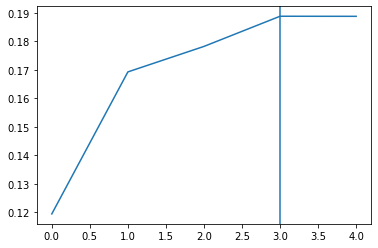

In [6]:
plt.plot(np.arange(0, 10., 1.)[:len(lnp_nospl_metric)], lnp_nospl_metric)
plt.axvline(np.arange(0, 10., 1.)[:len(lnp_nospl_metric)][np.argmax(lnp_nospl_metric)])

In [7]:
lnln_nospl = []
lnln_nospl_metric = []
lnln_nospl_time = []
num_subunits = 4
for beta in np.arange(0, 10., 1.):
    lnln = LNLN(X_train, y_train, dims=dims, dt=dt)
    lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
             num_subunits=num_subunits, num_iters=1500, verbose=300, tolerance=10,
             beta=beta, step_size=0.1, random_seed=2046,
             fit_history_filter=False)
    lnln_nospl.append(lnln)
    lnln_nospl_metric.append(lnln.metric_dev_opt)
    lnln_nospl_time.append(lnln.total_time_elapsed)
    
    if (np.diff(lnln_nospl_metric) > 0).all():
        continue
    else:
        break    

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     8.815	  2507.490	   543.918	     0.501	     0.078
  300	    60.772	 -1063.056	   550.344	     0.998	     0.070
  600	   114.166	 -1070.598	   635.138	     0.999	     0.063
Stop at 683 steps: cost (train) has been changing less than 1e-5 for 10 steps.

Total time elapsed: 128.903 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     7.337	  4415.475	   490.230	     0.511	     0.091
  300	    57.809	  -126.478	   145.270	     0.887	     0.160
  600	   111.239	  -146.981	   139.978	     0.877	     0.168
  900	   164.361	  -171.460	   148.043	     0.880	     0.146
 1200	   219.339	  -156.455	   147.795	     0.871	     0.135
Stop: reached 1500 steps.

Total time elapsed: 272.397 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     7.802	  5909.999	   402.501	     0.520	     0.096
  300	    58.158	   314.956	   113.036	     0.840	     0.204
  600	   115.0

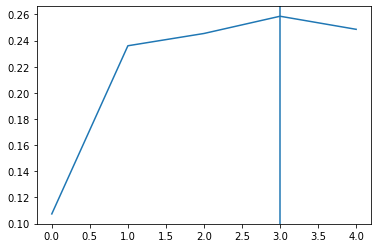

In [8]:
plt.plot(np.arange(0, 10., 1.)[:len(lnln_nospl_metric)], lnln_nospl_metric)
plt.axvline(np.arange(0, 10., 1.)[:len(lnln_nospl_metric)][np.argmax(lnln_nospl_metric)])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba05193110>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba05193b10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba0517e450>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba051705d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba05170a90>,
 'means': []}

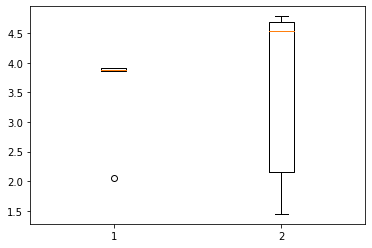

In [14]:
plt.boxplot([np.array(lnp_nospl_time)/60, np.array(lnln_nospl_time)/60])


In [15]:
lnp_nospl_time, lnln_nospl_time

([123.18076229095459,
  234.6336898803711,
  234.3747661113739,
  231.87712717056274,
  232.75508403778076],
 [128.9032781124115,
  272.3973939418793,
  287.16792488098145,
  281.545068025589,
  86.83727693557739])

In [16]:
lnp_nospl_best = lnp_nospl[np.argmax(lnp_nospl_metric)]
lnln_nospl_best = lnln_nospl[np.argmax(lnln_nospl_metric)]

In [23]:
def plot_vanilla(lnp0, lnln0, dt=None, shift=None, title=None, response_type='spike', len_time=1, contour=None, figsize=None):
    
    from rfest.utils import get_spatial_and_temporal_filters
    import matplotlib.gridspec as gridspec
    import warnings
    warnings.filterwarnings("ignore")
    
    dims = lnln0.dims
    dt = lnln0.dt if dt is None else dt
    shift = 0 if shift is None else -shift
    t_tRF = np.linspace(-(dims[0]-shift)*dt, shift*dt, dims[0]+1)[1:]

    fig = plt.figure(figsize=figsize) if figsize is not None else (12,4)
    
    for counter, (lnp, lnln) in enumerate([(lnp0, lnln0)]):
        
        (idx0, idx1) = (0, 1) if counter == 0 else (2, 3)

#         ws = uvec(lnln.w_opt)
        ws = lnln.w_opt
        num_subunits = ws.shape[1]

        sRFs_max = []
        sRFs_min = []
        tRFs = []
        for i in range(num_subunits):
            w = ws[:, i].reshape(dims)
            sRF, tRF = get_spatial_and_temporal_filters(w, dims)

            ref = [sRF[2:, 2:].max(), sRF[2:, 2:].min()][np.argmax([np.abs(sRF.max()), np.abs(sRF.min())])]
            max_coord = np.where(sRF == ref)
            tRF = w[:, max_coord[0], max_coord[1]].flatten()
            tRF_max = np.argmax(tRF)
            sRF_max = w[tRF_max]
            sRFs_max.append(sRF_max)
            tRF_min = np.argmin(tRF)
            sRF_min = w[tRF_min]
            sRFs_min.append(sRF_min)
            tRFs.append(tRF)

        sRFs_max = np.stack(sRFs_max)
        sRFs_min = np.stack(sRFs_min)

        vmax = np.max([np.abs(sRFs_max.max()), np.abs(sRFs_max.min()), np.abs(sRFs_min.max()), np.abs(sRFs_min.min())])

        ncols = num_subunits
        ncols += 2 # add lnp
        nrows = 4

        spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)  
        axs = []
        ax_sRF_mins= []
        ax_sRF_maxs = []    

        # LNP
        w_lnp = lnp.w_opt.reshape(dims)
        vmax_lnp = np.max([np.abs(w_lnp.max()), np.abs(w_lnp.min())])
        sRF_lnp, tRF_lnp = get_spatial_and_temporal_filters(w_lnp, dims)
        ref = [sRF_lnp[2:, 2:].max(), sRF_lnp[2:, 2:].min()][np.argmax([np.abs(sRF_lnp.max()), np.abs(sRF_lnp.min())])]
        max_coord = np.where(sRF_lnp == ref)
        tRF_lnp = w_lnp[:, max_coord[0], max_coord[1]].flatten()
        tRF_max = np.argmax(tRF_lnp)
        sRF_max = w_lnp[tRF_max]
        tRF_min = np.argmin(tRF_lnp)
        sRF_min = w_lnp[tRF_min]

        ax_sRF_min = fig.add_subplot(spec[0, 0])       
        ax_sRF_min.imshow(sRF_min, cmap=plt.cm.bwr, vmax=vmax_lnp, vmin=-vmax_lnp, aspect='auto')
        ax_sRF_min.set_xticks([])
        ax_sRF_min.set_yticks([])
        
        ax_sRF_max = fig.add_subplot(spec[1, 0])       
        ax_sRF_max.imshow(sRF_max, cmap=plt.cm.bwr, vmax=vmax_lnp, vmin=-vmax_lnp, aspect='auto')
        ax_sRF_max.set_xticks([])
        ax_sRF_max.set_yticks([])
        
        if counter == 0:
            ax_sRF_min.set_title(f'LNP')

        if counter == 0:
            ax_sRF_min.set_ylabel('No Spline')
        else:
            ax_sRF_min.set_ylabel('Spline')
            
        ax_sRF_mins.append(ax_sRF_min)
        
        ax_tRF = fig.add_subplot(spec[2, 0])       
        ax_tRF.plot(t_tRF, tRF_lnp, color='black')
        ax_tRF.spines['top'].set_visible(False)
        ax_tRF.spines['right'].set_visible(False)
#         ax_tRF.set_yticks([])
#         ax_tRF.set_xticks([])
        ax_tRF.set_xlabel('Time Lag (s)', fontsize=14)
#         tRF_max = np.argmax(tRFs[i])
        tRF_min = np.argmin(tRF_lnp)
#         ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
        ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
    
        vmax_tRF = np.max([np.abs(w_lnp.min()), np.abs(w_lnp.max()), np.abs(ws.min()), np.abs(ws.max())])
        ax_tRF.set_ylim(-vmax_tRF, vmax_tRF)
        # LNLN subunits

        for i in range(num_subunits):
            ax_sRF_min = fig.add_subplot(spec[0, i+1])       
            ax_sRF_min.imshow(sRFs_min[i], cmap=plt.cm.bwr, vmax=vmax, vmin=-vmax, aspect='auto')
            ax_sRF_min.set_xticks([])
            ax_sRF_min.set_yticks([])
            
            ax_sRF_max = fig.add_subplot(spec[1, i+1])       
            ax_sRF_max.imshow(sRFs_max[i], cmap=plt.cm.bwr, vmax=vmax, vmin=-vmax, aspect='auto')
            ax_sRF_max.set_xticks([])
            ax_sRF_max.set_yticks([])
            if i == 0 and counter == 0:
                ax_sRF_min.set_title(f'LNLN')

            ax_sRF_mins.append(ax_sRF_min)
            
            ax_tRF = fig.add_subplot(spec[2, i+1])       
            ax_tRF.plot(t_tRF, tRFs[i], color='black')
            ax_tRF.spines['top'].set_visible(False)
            ax_tRF.spines['right'].set_visible(False)
            ax_tRF.set_yticks([]) 
            
    #         tRF_max = np.argmax(tRFs[i])
            tRF_min = np.argmin(tRFs[i])
        
    #         ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
            ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
            ax_tRF.set_ylim(-vmax_tRF, vmax_tRF)
#             ax_tRF.set_ylim(-0.1, 0.1)


        if contour is not None and counter == 1: # then plot contour

            for i in range(num_subunits+1):

                color_min = 'black' if i == 0 else 'lightsteelblue'
                color_max = 'black' if i == 0 else 'lightcoral'

                ax_sRF_mins[i].contour(sRF_min, levels=[-contour], colors=[color_min], linestyles=['-'], alpha=1)

                for j in range(num_subunits):
                    if i-1 != j:
                        color = 'grey'
                        alpha = 0.5
                        style = '--'                    
                    else:
                        color = 'black'
                        alpha = 1
                        style = '--'
                    ax_sRF_mins[i].contour(sRFs_min[j], levels=[-contour], colors=[color], linestyles=[style], alpha=alpha)
            
    plt.subplots_adjust(wspace=0.5)






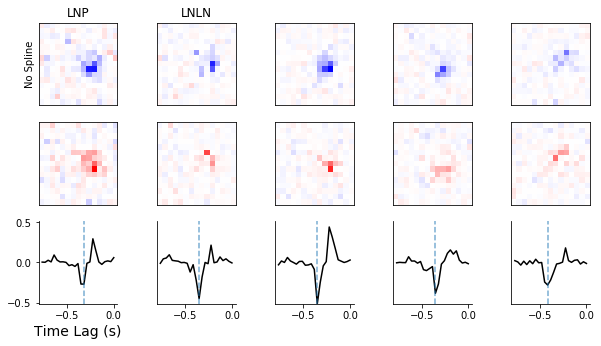

In [24]:
plot_vanilla(lnp_nospl_best, lnln_nospl_best, figsize=(12, 3.5*2))
# plt.savefig('figs/Figure8b1.pdf')

In [25]:
div = int(X_test.shape[0]/4)
cc_test_vanilla = np.array([[m.score(X_test[i*div:(i+1)*div], y_test[i*div:(i+1)*div]) for m in [lnp_nospl_best, lnln_nospl_best]] for i in range(4)])

In [26]:
cc_test_vanilla

array([[0.11237787, 0.10017895],
       [0.12187291, 0.19099434],
       [0.27587909, 0.35431198],
       [0.25295237, 0.27356057]])

### Select intial degrees of freedom based on cross-validated MLE prediction

In [5]:
i = 2
X, y, dt = upsample_data(stim, triggertime[:], trace[:, i], tracetime[:, i])
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(X, np.maximum(0, gaussian_filter(y, sigma=2, truncate=0.25)), dt, 
                                                                  frac_train=0.5, frac_dev=0.1, verbose=1)

SUMMARY
               N    Minutes   Fraction
Total      37531      20.02        1.0
Train      18769      10.01        0.5
Dev         3750        2.0        0.1
Test       15012       8.01        0.4


In [6]:
def build_model(df):
    
    m = GLM(distr='poisson', output_nonlinearity='softplus')
    m.add_design_matrix(X_train, dims=dims, df=df, smooth='cr', filter_nonlinearity='softplus', name='stimulus') # light stimulus
    m.add_design_matrix(X_dev, dims=dims, name='stimulus', kind='dev')
    m.initialize({'train': y_train, 'dev': y_dev}, num_subunits=1, dt=dt, method='mle', random_seed=2046)
    
    return m

In [12]:
dims = np.array([25, 15, 15])
np.ceil(dims * 1 / 3), np.ceil(dims * 2 / 3)

(array([9., 5., 5.]), array([17., 10., 10.]))

In [8]:
np.ceil(25 * 1 / 3), np.ceil(25 * 2 / 3)

(9.0, 17.0)

In [99]:
np.ceil(np.array(dims) * 1 / 3), np.floor(np.array(dims) * 2 / 3), 

(array([9., 5., 5.]), array([16., 10., 10.]))

In [100]:
import time
dfts = np.arange(9, 16+1, 1)
dfss = np.arange(5, 10+1, 1)

len(dfts), len(dfss)

(8, 6)

In [101]:
ms = []
results = {}
i = 0
heatmap = np.zeros([len(dfts), len(dfss)])
for ii, dft in enumerate(dfts):
    for jj, dfs in enumerate(dfss):
        df = [dft, dfs, dfs]
        time_start= time.time()
        m = build_model(df)
        time_elapsed = time.time() - time_start
        metric_dev = m._score(m.y['dev'], m.forwardpass(m.p['mle'], 'dev'), 'corrcoef')
        
        heatmap[ii, jj] = metric_dev
        
        results[i] = {'df': df, 'metric': metric_dev, 'time': time_elapsed}
        print(results[i])
        i+= 1

{'df': [9, 5, 5], 'metric': 0.10638344155756767, 'time': 1.5557570457458496}
{'df': [9, 6, 6], 'metric': 0.11341830613640805, 'time': 1.5808041095733643}
{'df': [9, 7, 7], 'metric': 0.1337821482703908, 'time': 2.025920867919922}
{'df': [9, 8, 8], 'metric': 0.16857455425191678, 'time': 2.4060518741607666}
{'df': [9, 9, 9], 'metric': 0.17661477307248993, 'time': 2.7879629135131836}
{'df': [9, 10, 10], 'metric': 0.17537062020695776, 'time': 3.357599973678589}
{'df': [10, 5, 5], 'metric': 0.10274273425130864, 'time': 1.4789440631866455}
{'df': [10, 6, 6], 'metric': 0.1112902517830275, 'time': 1.7820591926574707}
{'df': [10, 7, 7], 'metric': 0.1328351293330245, 'time': 2.103715658187866}
{'df': [10, 8, 8], 'metric': 0.16904913252125686, 'time': 2.567078113555908}
{'df': [10, 9, 9], 'metric': 0.1775352584171631, 'time': 3.067823648452759}
{'df': [10, 10, 10], 'metric': 0.17626271956650316, 'time': 3.7978460788726807}
{'df': [11, 5, 5], 'metric': 0.10099457848277438, 'time': 1.549784183502197

In [102]:
np.sum([results[i]['time'] for i in range(len(results))]) / 60

2.4456976850827536

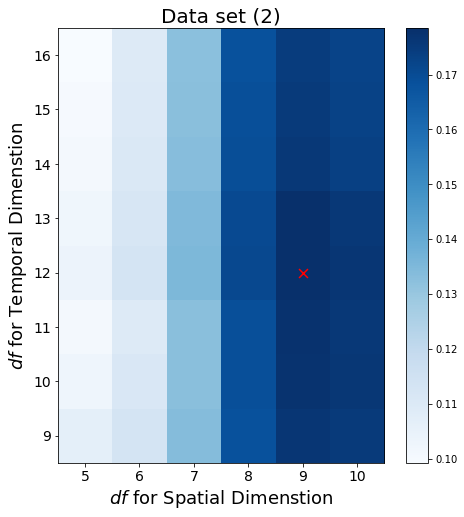

In [105]:
max_y, max_x = np.where(heatmap.max() == heatmap)
# max_y = 2
# max_x = 4
fig, ax = plt.subplots(figsize=(8,8))
cbar = ax.imshow(heatmap, cmap=plt.cm.Blues, origin='lower')
ax.set_xticklabels(np.hstack([0, dfss]), fontsize=14)
ax.set_yticklabels(np.hstack([0, dfts]), fontsize=14)
ax.scatter(max_x, max_y, color='red', marker='x', s=80)
ax.set_xlabel('$df$ for Spatial Dimenstion', fontsize=18)
ax.set_ylabel('$df$ for Temporal Dimenstion', fontsize=18)
fig.colorbar(cbar)
ax.set_title('Data set (2)', fontsize=20)
# cbar.set_label('CV performance')
fig.savefig('figs/Figure_CV_b.pdf')

In [84]:
ms_lnpspl = []
mdev_lnpspl = []
lnp_spl_time = []
df = [12, 9, 9]
for beta in np.arange(0.5 , 1.5, .1):
    
    lnp_spl = GLM(distr='poisson', output_nonlinearity='softplus')
    lnp_spl.add_design_matrix(X_train, dims=dims, df=df, smooth='cr', filter_nonlinearity='softplus', name='stimulus') # light stimulus
    lnp_spl.add_design_matrix(X_dev, name='stimulus', kind='dev')
    lnp_spl.initialize({'train': y_train, 'dev': y_dev}, num_subunits=1, dt=dt, method='mle', random_seed=2046)
    lnp_spl.fit(num_iters=1500, verbose=100, step_size=0.1, beta=beta)
    mdev_lnpspl.append(lnp_spl.metric_dev_opt)
    ms_lnpspl.append(lnp_spl)
    lnp_spl_time.append(lnp_spl.total_time_elapsed)
    print(beta, mdev_lnpspl[-1])
    plt.show()
    
    if (np.diff(mdev_lnpspl) > 0).all():
        continue
    else:
        break

Iters	  Time (s)	Cost (train)	Cost (dev)	corrcoef (train)	corrcoef (dev)
    0	     1.319	 21276.103	  4004.308	     0.064	     0.054
  100	     4.590	  3647.826	   716.140	     0.662	     0.298
  200	     7.881	  3617.532	   716.489	     0.667	     0.289
  300	    11.162	  3616.994	   717.455	     0.668	     0.288
  400	    15.366	  3617.174	   717.870	     0.668	     0.286
Stop at 421 steps: cost (dev) has been monotonically increasing for 10 steps.

0.5 0.2947700992902636
Iters	  Time (s)	Cost (train)	Cost (dev)	corrcoef (train)	corrcoef (dev)
    0	     1.379	 21285.973	  4003.210	     0.066	     0.057
  100	     4.715	  3670.149	   713.314	     0.653	     0.311
  200	     8.032	  3642.456	   712.532	     0.656	     0.304
  300	    11.362	  3641.918	   713.693	     0.657	     0.300
  400	    15.635	  3642.139	   713.584	     0.656	     0.302
  500	    19.905	  3642.143	   713.848	     0.657	     0.301
  600	    24.114	  3642.339	   713.594	     0.656	     0.302
  700	    28.331	  3

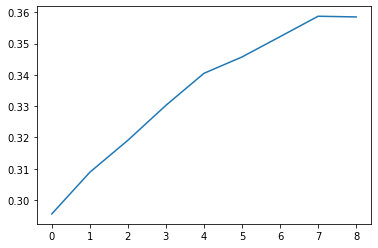

In [41]:
plt.plot(mdev_lnpspl)

In [42]:
lnp_nospl_time= [123.18076229095459,
  234.6336898803711,
  234.3747661113739,
  231.87712717056274,
  232.75508403778076]
lnln_nospl_time=[128.9032781124115,
  272.3973939418793,
  287.16792488098145,
  281.545068025589,
  86.83727693557739]

In [43]:
np.array(lnp_spl_time)

array([24.97751999, 39.78730392, 22.27571201, 13.62859082, 12.8681159 ,
       13.05415034, 12.15735793, 45.32645297, 14.0872941 ])

In [46]:
ms_lnlnspl = []
mdev_lnlnspl = []
lnln_spl_time = []

for beta in np.arange(0.5 , 1.5, .1):
    
    lnln_spl = GLM(distr='poisson', output_nonlinearity='softplus')
    lnln_spl.add_design_matrix(X_train, dims=dims, df=df, smooth='cr', filter_nonlinearity='softplus', name='stimulus') # light stimulus
    lnln_spl.add_design_matrix(X_dev, name='stimulus', kind='dev')
    lnln_spl.initialize({'train': y_train, 'dev': y_dev}, num_subunits=4, dt=dt, method='mle', random_seed=2046)
    lnln_spl.fit(num_iters=1500, verbose=100, step_size=0.1, beta=beta)
    
    mdev_lnlnspl.append(lnln_spl.metric_dev_opt)
    ms_lnlnspl.append(lnln_spl)
    lnln_spl_time.append(lnln_spl.total_time_elapsed)
    
    print(beta, mdev_lnlnspl[-1])
    plt.show()
    
    if (np.diff(mdev_lnlnspl) > 0).all():
        continue
    else:
        break

Iters	  Time (s)	Cost (train)	Cost (dev)	corrcoef (train)	corrcoef (dev)
    0	     1.901	 53500.782	 10384.513	     0.052	     0.034
  100	    12.923	  3906.320	   756.635	     0.613	     0.303
  200	    23.960	  3672.668	   713.816	     0.651	     0.316
  300	    34.869	  3615.354	   709.973	     0.698	     0.323
  400	    46.872	  3600.992	   709.199	     0.713	     0.333
  500	    58.811	  3596.652	   709.767	     0.719	     0.334
  600	    70.680	  3595.243	   711.905	     0.722	     0.331
  700	    82.518	  3595.121	   712.635	     0.722	     0.332
  800	    94.378	  3595.058	   713.307	     0.723	     0.329
  900	   106.182	  3595.463	   713.161	     0.722	     0.331
 1000	   118.071	  3595.972	   713.917	     0.723	     0.328
 1100	   129.946	  3596.021	   713.483	     0.723	     0.328
 1200	   141.772	  3595.990	   713.531	     0.724	     0.328
Stop at 1279 steps: cost (dev) has been monotonically increasing for 10 steps.

0.5 0.3357273330452972
Iters	  Time (s)	Cost (train)	C

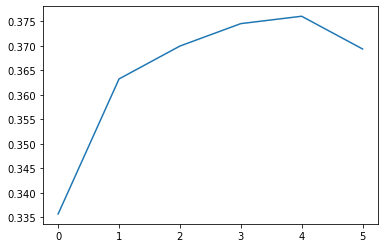

In [48]:
plt.plot(mdev_lnlnspl)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb58e4223d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb63c588750>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb63c3971d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb58e429bd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb58e4348d0>,
 'means': []}

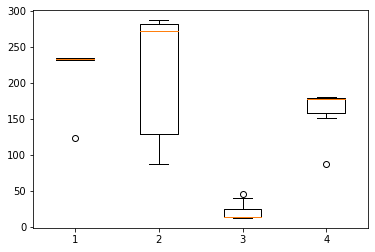

In [49]:
plt.boxplot([np.array(lnp_nospl_time), np.array(lnln_nospl_time), np.array(lnp_spl_time), np.array(lnln_spl_time)])

In [50]:
lnp_spl = ms_lnpspl[np.argmax(mdev_lnpspl)]
lnln_spl = ms_lnlnspl[np.argmax(mdev_lnlnspl)]

In [82]:
from rfest.check import significance

def plot_spline(lnp0, lnln0, dt=None, shift=None, title=None, response_type='spike', len_time=1, contour=None, figsize=None):
    
    from rfest.utils import get_spatial_and_temporal_filters
    import matplotlib.gridspec as gridspec
    import warnings
    warnings.filterwarnings("ignore")
    
    dims = lnln0.dims['stimulus']
    dt = lnln0.dt if dt is None else dt
    shift = 0 if shift is None else -shift
    t_tRF = np.linspace(-(dims[0]-shift)*dt, shift*dt, dims[0]+1)[1:]

    W_score_lnp, p_values_lnp = significance(lnp0, 'opt')
    W_score_lnln, p_values_lnln = significance(lnln0, 'opt')
    
    fig = plt.figure(figsize=figsize) if figsize is not None else (12,4)
    
    for counter, (lnp, lnln) in enumerate([(lnp0, lnln0)]):
        
        (idx0, idx1) = (0, 1) if counter == 0 else (2, 3)

#         ws = uvec(lnln.w_opt)
        ws = np.hstack([lnln.w['opt'][name] for name in lnln.w['opt']])
        num_subunits = ws.shape[1]

        sRFs_max = []
        sRFs_min = []
        tRFs = []
        tRFs_u = []
        tRFs_l = []
        for i, name in enumerate(lnln0.filter_names):
            w = lnln.w['opt'][name].flatten()
            w_se = lnln.w_se['opt'][name].flatten()
            wu = w + 2 * w_se
            wl = w - 2 * w_se
            
            w = w.reshape(dims)
            wu = wu.reshape(dims)
            wl = wl.reshape(dims)
            
            sRF, tRF = get_spatial_and_temporal_filters(w, dims)

            ref = [sRF[2:, 2:].max(), sRF[2:, 2:].min()][np.argmax([np.abs(sRF.max()), np.abs(sRF.min())])]
            max_coord = np.where(sRF == ref)
            tRF = w[:, max_coord[0], max_coord[1]].flatten()
            tRFu = wu[:, max_coord[0], max_coord[1]].flatten()
            tRFl = wl[:, max_coord[0], max_coord[1]].flatten()

            tRF_max = np.argmax(tRF)
            sRF_max = w[tRF_max]
            sRFs_max.append(sRF_max)
            tRF_min = np.argmin(tRF)
            sRF_min = w[tRF_min]
            sRFs_min.append(sRF_min)
            tRFs.append(tRF)
            tRFs_u.append(tRFu)
            tRFs_l.append(tRFl)

        sRFs_max = np.stack(sRFs_max)
        sRFs_min = np.stack(sRFs_min)

        vmax = np.max([np.abs(sRFs_max.max()), np.abs(sRFs_max.min()), np.abs(sRFs_min.max()), np.abs(sRFs_min.min())])

        ncols = num_subunits
        ncols += 2 # add lnp
        nrows = 4

        spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)  
        axs = []
        ax_sRF_mins= []
        ax_sRF_maxs = []    

        # LNP
        w_lnp = lnp.w['opt']['stimulus'].flatten()
        w_se_lnp = lnp.w_se['opt']['stimulus'].flatten()
        wu_lnp = w_lnp + 2 * w_se_lnp
        wl_lnp = w_lnp - 2 * w_se_lnp
        
        w_lnp = w_lnp.reshape(dims)
        wu_lnp = wu_lnp.reshape(dims)
        wl_lnp = wl_lnp.reshape(dims)
        
        vmax_lnp = np.max([np.abs(w_lnp.max()), np.abs(w_lnp.min())])
        sRF_lnp, tRF_lnp = get_spatial_and_temporal_filters(w_lnp, dims)
        ref = [sRF_lnp[2:, 2:].max(), sRF_lnp[2:, 2:].min()][np.argmax([np.abs(sRF_lnp.max()), np.abs(sRF_lnp.min())])]
        max_coord = np.where(sRF_lnp == ref)
        
        tRF_lnp = w_lnp[:, max_coord[0], max_coord[1]].flatten()
        tRFu_lnp = wu_lnp[:, max_coord[0], max_coord[1]].flatten()
        tRFl_lnp = wl_lnp[:, max_coord[0], max_coord[1]].flatten()
        
        tRF_max = np.argmax(tRF_lnp)
        sRF_max = w_lnp[tRF_max]
        tRF_min = np.argmin(tRF_lnp)
        sRF_min = w_lnp[tRF_min]

        ax_sRF_min = fig.add_subplot(spec[0, 0])       
        ax_sRF_min.imshow(sRF_min, cmap=plt.cm.bwr, vmax=vmax_lnp, vmin=-vmax_lnp, aspect='auto')
        ax_sRF_min.set_xticks([])
        ax_sRF_min.set_yticks([])
        
        ax_sRF_max = fig.add_subplot(spec[1, 0])       
        ax_sRF_max.imshow(sRF_max, cmap=plt.cm.bwr, vmax=vmax_lnp, vmin=-vmax_lnp, aspect='auto')
        ax_sRF_max.set_xticks([])
        ax_sRF_max.set_yticks([])
#         ax_sRF_min.set_title(f'')
        p = p_values_lnp['stimulus']

        stars = '*'

        if p < 0.001:
            stars *= 3
            ax_sRF_min.set_title(f'p<0.001{stars} ', fontsize=14)
        elif p<0.01:
            stars *= 2
            ax_sRF_min.set_title(f'p<0.01{stars} ', fontsize=14)
        elif p<0.05:
            stars *= 1
            ax_sRF_min.set_title(f'p<0.05{stars} ', fontsize=14)
        else:
            stars = '[n.s.]'
            ax_sRF_min.set_title(f'p>0.05{stars} ', fontsize=14)

#         ax_sRF_min.set_ylabel('Spline')
            
        ax_sRF_mins.append(ax_sRF_min)
        ax_sRF_maxs.append(ax_sRF_max)

        
        ax_tRF = fig.add_subplot(spec[2, 0])       
        ax_tRF.plot(t_tRF, tRF_lnp, color='black')
        ax_tRF.fill_between(t_tRF, tRFu_lnp, tRFl_lnp, color='gray', alpha=0.5)


        ax_tRF.spines['top'].set_visible(False)
        ax_tRF.spines['right'].set_visible(False)
#         ax_tRF.set_yticks([])
#         ax_tRF.set_xticks([])
#         tRF_max = np.argmax(tRFs[i])
        tRF_min = np.argmin(tRF_lnp)
        ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
        ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
        ax_tRF.set_xlabel('Time Lag (s)', fontsize=14)

    
        vmax_tRF = np.max([np.abs(w_lnp.min()), np.abs(w_lnp.max()), np.abs(ws.min()), np.abs(ws.max())])
        ax_tRF.set_ylim(-vmax_tRF, vmax_tRF)
        # LNLN subunits

        for i, name in enumerate(lnln0.filter_names):
            ax_sRF_min = fig.add_subplot(spec[0, i+1])       
            ax_sRF_min.imshow(sRFs_min[i], cmap=plt.cm.bwr, vmax=vmax, vmin=-vmax, aspect='auto')
            ax_sRF_min.set_xticks([])
            ax_sRF_min.set_yticks([])
            
            ax_sRF_max = fig.add_subplot(spec[1, i+1])       
            ax_sRF_max.imshow(sRFs_max[i], cmap=plt.cm.bwr, vmax=vmax, vmin=-vmax, aspect='auto')
            ax_sRF_max.set_xticks([])
            ax_sRF_max.set_yticks([])            

            if i == 0 and counter == 0:
                ax_sRF_min.set_title(f'LNLN')

            ax_sRF_mins.append(ax_sRF_min)
            ax_sRF_maxs.append(ax_sRF_max)

            
            ax_tRF = fig.add_subplot(spec[2, i+1])       
            ax_tRF.plot(t_tRF, tRFs[i], color='black')
            ax_tRF.fill_between(t_tRF, tRFs_u[i], tRFs_l[i], color='gray', alpha=0.5)
            ax_tRF.spines['top'].set_visible(False)
            ax_tRF.spines['right'].set_visible(False)
            ax_tRF.set_yticks([]) 
#             ax_tRF.set_xticks([])
    #         tRF_max = np.argmax(tRFs[i])
            tRF_min = np.argmin(tRFs[i])
            
            ax_tRF.axvline(t_tRF[tRF_max], color='C3', linestyle='--', alpha=0.6)
            ax_tRF.axvline(t_tRF[tRF_min], color='C0', linestyle='--', alpha=0.6)
            ax_tRF.set_ylim(-vmax_tRF, vmax_tRF)
#             ax_tRF.set_ylim(-0.1, 0.1)

            p = p_values_lnln[name]

            stars = '*'

            if p < 0.001:
                stars *= 3
                ax_sRF_min.set_title(f'p<0.001{stars} ', fontsize=14)
            elif p<0.01:
                stars *= 2
                ax_sRF_min.set_title(f'p<0.01{stars} ', fontsize=14)
            elif p<0.05:
                stars *= 1
                ax_sRF_min.set_title(f'p<0.05{stars} ', fontsize=14)
            else:
                stars = '[n.s.]'
                ax_sRF_min.set_title(f'p>0.05{stars} ', fontsize=14)

        if contour is not None and counter == 0: # then plot contour

            for i in range(num_subunits+1):

                color_min = 'black' if i == 0 else 'gray'
                color_max = 'black' if i == 0 else 'gray'

                ax_sRF_mins[i].contour(sRF_min, levels=[-contour], colors=[color_min], linestyles=['-'], alpha=1)
                ax_sRF_maxs[i].contour(sRF_max, levels=[contour], colors=[color_max], linestyles=['-'], alpha=1)


                for j in range(num_subunits):
                    if i-1 != j:
                        color = 'grey'
                        alpha = 0.5
                        style = '--'                    
                    else:
                        color = 'black'
                        alpha = 1
                        style = '--'
                    ax_sRF_mins[i].contour(sRFs_min[j], levels=[-contour], colors=[color], linestyles=[style], alpha=alpha)
                    ax_sRF_maxs[i].contour(sRFs_max[j], levels=[contour], colors=[color], linestyles=[style], alpha=alpha)

            
    plt.subplots_adjust(wspace=0.5)







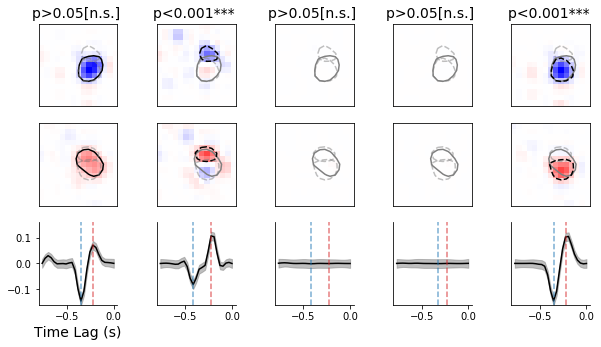

In [83]:
plot_spline(lnp_spl, lnln_spl, figsize=(12, 3.5*2), contour=0.035)
plt.savefig('figs/Figure8b2.pdf')

In [81]:
significance(lnp_spl)

({'stimulus': DeviceArray(946.78104462, dtype=float64)},
 {'stimulus': 0.7128896950675678})

In [53]:
div = int(X_test.shape[0]/4)
cc_test_spline = np.array([[m.score(X_test[i*div:(i+1)*div], y_test[i*div:(i+1)*div]) for m in [lnp_spl, lnln_spl]] for i in range(4)])

In [54]:
cc_test_vanilla= np.array([[0.11237787, 0.10017895],
       [0.12187291, 0.19099434],
       [0.27587909, 0.35431198],
       [0.25295237, 0.27356057]])

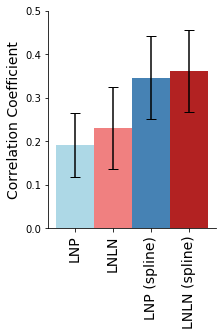

In [55]:
cc_test = np.hstack([cc_test_vanilla, cc_test_spline])
cc_test_mean = cc_test.mean(0)


cc_test_std = cc_test.std(0)
fig, ax_bar = plt.subplots(figsize=(3,4))

x = [0, 1, 2, 3]
ax_bar.bar(x, cc_test_mean, yerr=cc_test_std, width=1, color=['lightblue', 'lightcoral', 'steelblue', 'firebrick'], capsize=5)
labels = ['LNP',  'LNLN', 'LNP (spline)', 'LNLN (spline)']

ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(labels, rotation=90, fontsize=14)
ax_bar.set_ylim(0, 0.5)
ax_bar.set_ylabel('Correlation Coefficient', fontsize=14)

plt.savefig('figs/Figure8b3.pdf')

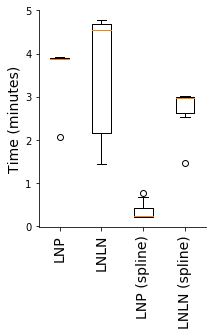

In [56]:
fig, ax_box = plt.subplots(figsize=(3,4))
ax_box.boxplot([np.array(lnp_nospl_time)/60, np.array(lnln_nospl_time)/60, np.array(lnp_spl_time)/60, np.array(lnln_spl_time)/60])

labels = ['LNP',  'LNLN', 'LNP (spline)', 'LNLN (spline)']

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.set_ylabel('Time (minutes)', fontsize=14)
# ax_box.set_xticks(x)
ax_box.set_xticklabels(labels, rotation=90, fontsize=14)

plt.savefig('figs/Figure8b4.pdf')